# Balance a pole on a cart with DQN
<br>
In this notebook we'll build a Deep Q-Network with TensorFlow deep learning framework and OpenAI gym <a href='https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py'>CartPole-v0</a> environment to balance a pole on a cart. <br><br><br>

# CartPole-v0

<br><br>

<img src='./images/CartPole-v1.gif'>
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center. <br><br><br>

In [1]:
import gym
import random
import numpy as np
import tensorflow as tf

In [2]:
tf.reset_default_graph()

In [3]:
class DQN:
    def __init__(self, input_shape:object = None, action_size:object = None, scope:object = None) -> object:

        if input_shape is None:
            input_shape = [None, 4]
        self.max_size = 1000000
        self.mem = []

        with tf.variable_scope(scope):
            self.scope = scope
            self.input_shape = input_shape
            self.action_size = action_size

            self.states = tf.placeholder(shape=input_shape, dtype=tf.float32)
            self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
            self.actions_onehot = tf.one_hot(
                self.actions, action_size, dtype=tf.float32)

            fc1 = tf.layers.dense(self.states, 256, activation=tf.nn.relu)
            fc2 = tf.layers.dense(fc1, 256, activation=tf.nn.relu)
            self.q = tf.layers.dense(fc2, action_size, activation=None)

            self.target_q = tf.placeholder(shape=[None], dtype=tf.float32)
            self.responsible_output = tf.reduce_sum(tf.multiply(
                self.q, self.actions_onehot), axis=1, keep_dims=False)
            self.loss = tf.reduce_mean(
                tf.square(self.responsible_output - self.target_q))

            self.update_model = tf.train.AdamOptimizer().minimize(self.loss)

    def action(self, sess, state):
        q = sess.run(self.q, feed_dict={self.states: state[np.newaxis, ...]})
        return np.argmax(q)

    def train(self, sess, batch, learning_rate, tnet):
        assert len(batch) > 0
        states = np.vstack(batch[:, 0])
        actions = np.array(batch[:, 1])
        rewards = batch[:, 2]
        next_states = np.vstack(batch[:, 3])
        dones = batch[:, 4]

        next_q = sess.run(tnet.q, feed_dict={tnet.states: next_states})

        next_q = rewards + (1. - dones.astype(np.float32)) * \
            learning_rate * np.amax(next_q, axis=1, keepdims=False)

        sess.run(self.update_model, feed_dict={self.states: states,
                                               self.actions: actions,
                                               self.target_q: next_q})

    def add(self, element):
        self.mem.append(element)

        if len(self.mem) > self.max_size:
            self.mem.pop(0)

    def sample(self, size):
        size = min(size, len(self.mem))
        return random.sample(self.mem, size)


    def update_graph(self, from_graph:object, to_graph:object) -> object:
        from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, from_graph)
        to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, to_graph)
    
        holder = []
        for from_var, to_var in zip(from_vars, to_vars):
            holder.append(to_var.assign(from_var))
        return holder

In [4]:
target_update = 200
epsilon_max = 1.0
epsilon_min = 0.01
epsilon_decay = 0.001
learning_rate = 0.99
batch_size = 64
EPISODES = 300



env = gym.make('CartPole-v0')
action_size = env.action_space.n
input_shape = [None] + list(env.observation_space.shape)

time_step = 0.0
epsilon = epsilon_max

Q_Network = DQN(input_shape=input_shape,
                action_size=action_size, scope='Q_Network')
Target_Network = DQN(input_shape=input_shape,
                    action_size=action_size, scope='Target_Network')

update_ops = Q_Network.update_graph('Q_Network', 'Target_Network')

saver = tf.train.Saver()
score = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(EPISODES):
        total_reward = 0
        state = env.reset()
        while True:
            env.render()
            if np.random.rand() < epsilon:
                action = np.random.randint(action_size)
            else:
                action = Q_Network.action(sess, state)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            Q_Network.add([state, action, reward, next_state, done])

            time_step += 1.
            epsilon = epsilon_min + \
                (epsilon_max - epsilon_min) * \
                np.exp(-epsilon_decay * time_step)

            batch = np.array(Q_Network.sample(batch_size))
            Q_Network.train(sess, batch, learning_rate, Target_Network)

            state = np.copy(next_state)

            if int(time_step) % target_update == 0:
                sess.run(update_ops)
                saver.save(sess, "./checkpoints/CartPole_DQN.ckpt")

            if done:
                print('Epoch:', epoch, 'Total Rewards:', total_reward)
                score.append(total_reward)
                break
                
env.close()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch: 0 Total Rewards: 15.0
Epoch: 1 Total Rewards: 19.0
Epoch: 2 Total Rewards: 17.0
Epoch: 3 Total Rewards: 18.0
Epoch: 4 Total Rewards: 17.0
Epoch: 5 Total Rewards: 16.0
Epoch: 6 Total Rewards: 14.0
Epoch: 7 Total Rewards: 48.0
Epoch: 8 Total Rewards: 36.0
Epoch: 9 Total Rewards: 11.0
Epoch: 10 Total Rewards: 14.0
Epoch: 11 Total Rewards: 14.0
Epoch: 12 Total Rewards: 53.0
Epoch: 13 Total Rewards: 17.0
Epoch: 14 Total Rewards: 40.0
Epoch: 15 Total Rewards: 17.0
Epoch: 16 Total Rewards: 36.0
Epoch: 17 Total Rewards: 20.0
Epoch: 18 Total Rewards: 48.0
Epoch: 19 Total Rewards: 14.0
Epoch: 20 Total Rewards: 18.0
Epoch: 21 Total Rewards: 21.0
Epoch: 22 Total Rewards: 27.0
Epoch: 23 Total Rewards: 18.0
Epoch: 24 Total Rewards: 39.0
Epoch: 25 Total Rewards: 38.0
Epoch: 26 Total Rewards: 15.0
Epoch: 27 Total Rewards: 33.0
Epoch: 28 Total Rewards: 35.0
Epoch: 29 Total Rewards: 38.0
Epoch: 30 Total Rewards: 37.0
Epoch: 

Epoch: 253 Total Rewards: 200.0
Epoch: 254 Total Rewards: 200.0
Epoch: 255 Total Rewards: 200.0
Epoch: 256 Total Rewards: 200.0
Epoch: 257 Total Rewards: 196.0
Epoch: 258 Total Rewards: 200.0
Epoch: 259 Total Rewards: 200.0
Epoch: 260 Total Rewards: 200.0
Epoch: 261 Total Rewards: 200.0
Epoch: 262 Total Rewards: 130.0
Epoch: 263 Total Rewards: 200.0
Epoch: 264 Total Rewards: 200.0
Epoch: 265 Total Rewards: 200.0
Epoch: 266 Total Rewards: 200.0
Epoch: 267 Total Rewards: 200.0
Epoch: 268 Total Rewards: 179.0
Epoch: 269 Total Rewards: 200.0
Epoch: 270 Total Rewards: 188.0
Epoch: 271 Total Rewards: 200.0
Epoch: 272 Total Rewards: 200.0
Epoch: 273 Total Rewards: 200.0
Epoch: 274 Total Rewards: 180.0
Epoch: 275 Total Rewards: 196.0
Epoch: 276 Total Rewards: 168.0
Epoch: 277 Total Rewards: 130.0
Epoch: 278 Total Rewards: 125.0
Epoch: 279 Total Rewards: 110.0
Epoch: 280 Total Rewards: 132.0
Epoch: 281 Total Rewards: 118.0
Epoch: 282 Total Rewards: 151.0
Epoch: 283 Total Rewards: 115.0
Epoch: 2

## Fundamental Performance Analysis

In [5]:
score = np.array(score)
totla_epoch = len(score)

print("Total Epoch:", totla_epoch)
print("Min Reward:", score.min())
print("Max Reward:", score.max())
print("Average Reward:", score.mean())
print("Highest Performance:", score.max(), "Reached at:", np.argmax(score) + 1, "Episode")

Total Epoch: 300
Min Reward: 11.0
Max Reward: 200.0
Average Reward: 137.99
Highest Performance: 200.0 Reached at: 50 Episode


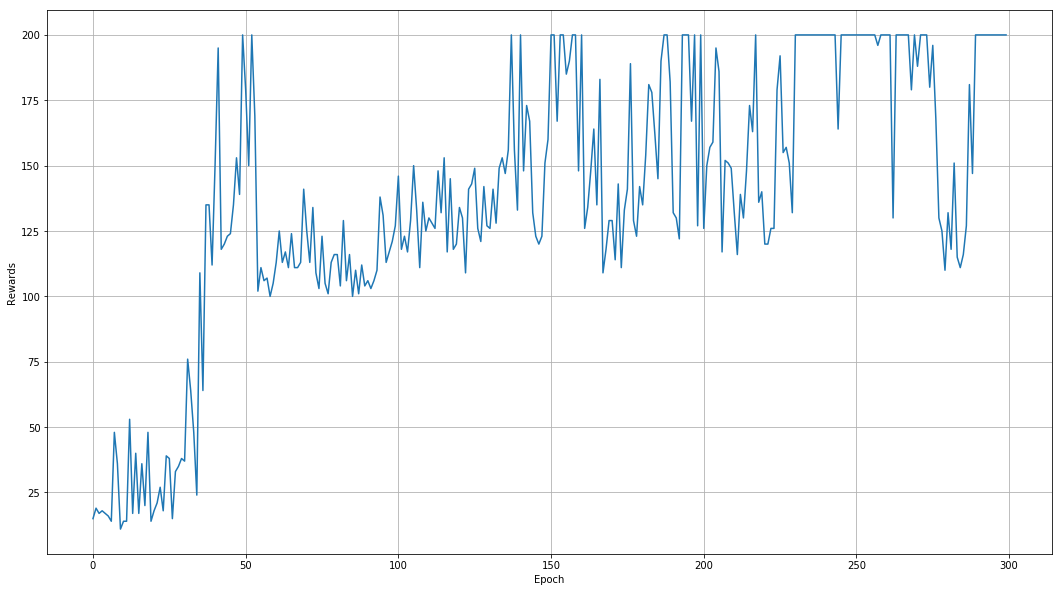

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(18,10))
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Rewards")
plt.plot(range(totla_epoch), score)
plt.show()